## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [ ]:
!pip install gym-minigrid &>/dev/null

In [ ]:
!git clone https://github.com/kehemo/uaas

Cloning into 'uaas'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 13 (delta 3), reused 4 (delta 1), pack-reused 0
Receiving objects: 100% (13/13), 419.98 KiB | 2.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [15]:
from uaas.foo import *

## Run Reinforce

Great!  Now let's run our implementation, and see how we do.

In [16]:
args = Config()
df = run_experiment(args, update_parameters_reinforce)

df.plot(x='num_frames', y='reward')

  1%|          | 14/2000 [00:10<25:26,  1.30it/s]


KeyboardInterrupt: 

## REINFORCE with Discounted Reward

Uh oh! Even after 300,000 steps, our policy does not converge. One reason for failure is the way rewards are generated in the real-world. In an ideal world, the agent would be rewarded at every timestep in a manner that perfectly corresponded to the quality of the action taken in a particular state.  However, this is rarely the case; for example, in Doorkey we only get reward at the very end of the episode (i.e., the sparse reward scenario).

Oh, the reward is binary and difficult to see the improvement since it depends on the density of the blue bar in the plot. So, we smooth reward by averaging certain amount of rewards from previous episode (`smooth_reward`).

Fill in `compute_discounted_return` code block above, then run code cell below to see the effect of discounted reward trajectories.  This should converge, so if it doesn't, you've made an error (although try re-running the cell a few times first to make sure it's not a bad random seed). **(10 pts)**



 32%|███▏      | 640/2000 [03:54<08:18,  2.73it/s]


Solved!


<Axes: xlabel='num_frames'>

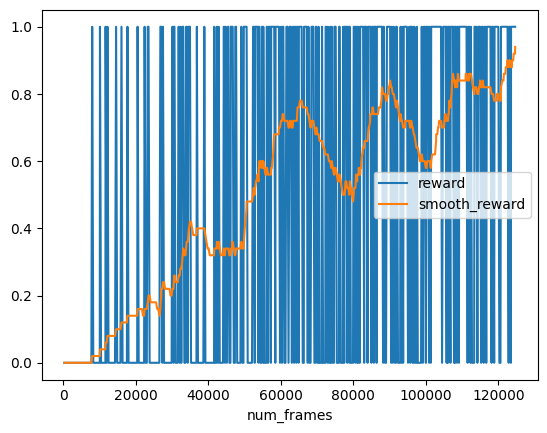

In [ ]:
args = Config(use_discounted_reward=True)
df = run_experiment(args, update_parameters_reinforce)

df.plot(x='num_frames', y=['reward', 'smooth_reward'])

## Run REINFORCE with baseline

If you did everything right, you should be able to run the below cell to run the vanilla policy gradients implementation with baseline.  This should be somewhat more stable than without the baseline, and likely converge faster.


 23%|██▎       | 466/2000 [04:00<13:12,  1.94it/s]

Solved!


<Axes: xlabel='num_frames'>

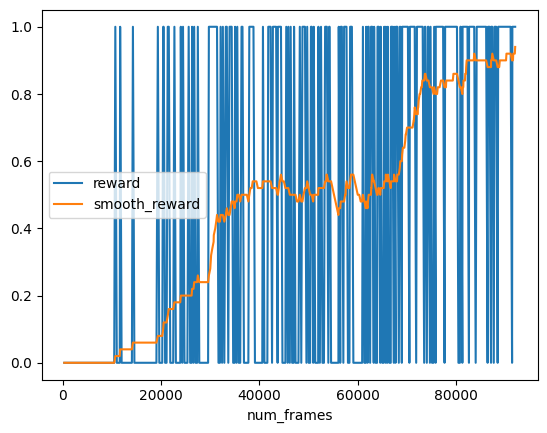

In [ ]:
args = Config(use_critic=True)
df_baseline = run_experiment(args, update_parameters_with_baseline)

df_baseline.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Reinforce with GAE

The advantage we computed above seemed to work, and hopefully improved our results! Fortunately, we can do even better. The paper Generalized Advantage Estimation describes a nifty method for building a strong advantage estimate (see formula 16 in the paper) that empirically outperforms a naive subtraction (and includes reward shaping). Implemented the GAE function we left blank from earlier.

 28%|██▊       | 563/2000 [04:31<11:32,  2.08it/s]

Solved!


<Axes: xlabel='num_frames'>

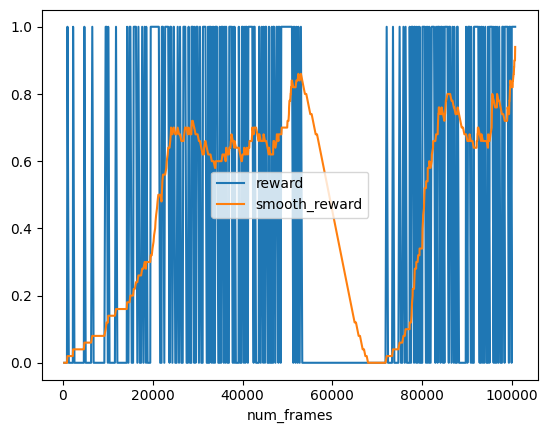

In [ ]:
args = Config(use_critic=True, use_gae=True)
df_gae = run_experiment(args, update_parameters_with_baseline)

df_gae.plot(x='num_frames', y=['reward', 'smooth_reward'])

# Fancy Plots
If you've gotten to this point, congrats: you've succesfully implemented REINFORCE, VPG, and GAE!

**(10 pts)** Now let's visualize every result in one plot.

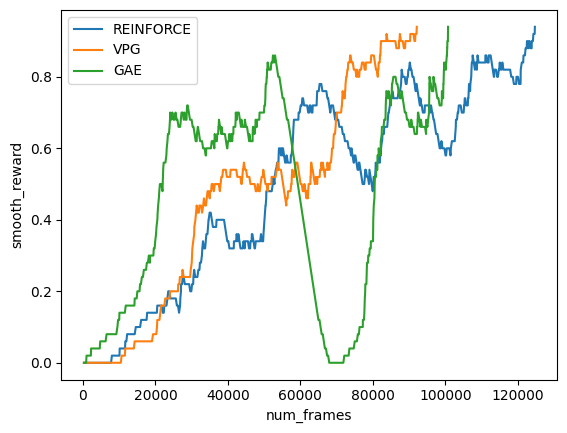

In [ ]:
# TODO Visualize all results into one plot.

# plot(df['num_frames'], df['smooth_reward'])

ax = None
for t, name in ((df, 'REINFORCE'), (df_baseline, 'VPG'), (df_gae, 'GAE')):
  t = t.rename(columns={'smooth_reward': name})
  ax = t.plot(ax=ax, x='num_frames', y=name, ylabel='smooth_reward')